In [1]:
import matplotlib.pyplot as plt
from IPython import display

import numpy as np
import torch
from torch import nn

from tqdm import tqdm_notebook as tqdm

from advopt.tasks import PythiaTracker
from advopt.classifier.nn import rolling, fixed_size

from advopt.classifier import Network, Dense
from advopt.classifier import lincapacity, logcapacity
from advopt.classifier import l2_reg, grad_reg, r1_reg
from advopt.opt import variational_optimization

/mnt/mborisyak/opt/pyenv/versions/3.6.6/envs/py3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
DEVICE = 'cuda:0'
BUDGET = 32 * 1024

In [3]:
task = PythiaTracker(seed=1222, n_jobs=8)

In [4]:
from advopt.classifier import Network

const_reg = r1_reg(coef=1.0)

net_drop = Network(
    Dense(task.ndim(), dropout=True),
    device=DEVICE, min_stagnation=1024,
    regularization=None, capacity=lincapacity(3),
    const_regularization=const_reg,
    stop_diff=1e-1
)
net_reg = Network(
    Dense(task.ndim(), dropout=False),
    device=DEVICE, min_stagnation=1024,
    regularization=l2_reg(1e-2), capacity=logcapacity(10),
    const_regularization=const_reg,
    stop_diff=1e-1
)
net_control = Network(
    Dense(task.ndim(), dropout=False),
    device=DEVICE, min_stagnation=1024,
    stop_diff=1e-1,
    regularization=None,
    const_regularization=const_reg
)

In [ ]:
results_control = variational_optimization(
    metric=rolling(size_step=128, target_diff=5e-2, progress=tqdm),
    mean0=[0.75, 0.75, 0.75],
    sigma0=0.2,
    sigma_min=0.1,
    device=DEVICE
)(task, BUDGET, net_control, seed=111)

In [ ]:
results_drop = variational_optimization(
    metric=rolling(size_step=128, target_diff=5e-2, progress=tqdm),
    mean0=[0.75, 0.75, 0.75],
    sigma0=0.2,
    sigma_min=0.1,
    device=DEVICE
)(task, BUDGET, net_drop, seed=111)

In [ ]:
results_reg = variational_optimization(
    metric=rolling(size_step=128, target_diff=5e-2, progress=tqdm),
    mean0=[0.75, 0.75, 0.75],
    sigma0=0.2,
    sigma_min=0.1,
    device=DEVICE
)(task, BUDGET, net_reg, seed=111)

In [ ]:
import pickle
import os

DATA_ROOT=os.path.join(
    os.environ.get('DATA_ROOT', './'),
    'RAO'
)

with open(os.path.join(DATA_ROOT, 'AVO-dense-%d.pickled') % (BUDGET, ), 'wb') as f:
    pickle.dump({
        'dropout' : results_drop,
        'l2' : results_reg,
        'control' : results_control
    }, f)

In [7]:
import pickle
import os

DATA_ROOT=os.path.join(
    os.environ.get('DATA_ROOT', './'),
    'RAO'
)

with open(os.path.join(DATA_ROOT, 'AVO-dense.pickled'), 'rb') as f:
    results = pickle.load(f)

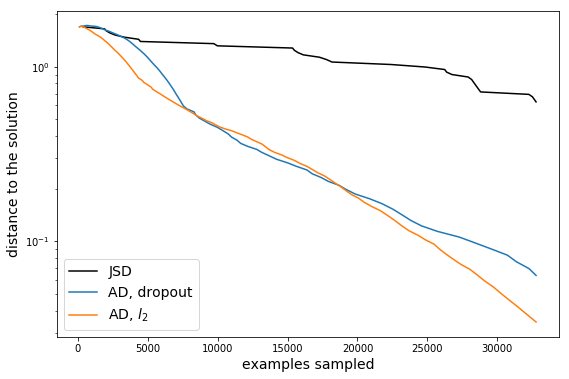

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9, 6))

labels = {
    'control' : 'JSD',
    'dropout' : 'AD, dropout',
    'l2' : 'AD, l2',
}

colors = {
    'control' : 'black',
    'dropout' : plt.cm.tab10(0),
    'l2' : plt.cm.tab10(1),
}

for name in labels:
    plt.plot(
        np.cumsum(results[name].costs),
        np.sum(np.array(results[name].points) ** 2, axis=1),
        label=labels[name],
        color=colors[name]
    )

plt.yscale('log')
plt.xlabel('examples sampled', fontsize=14)
plt.ylabel('distance to the solution', fontsize=14)
plt.legend(loc='lower left', fontsize=14)
plt.savefig('AVO-dense.pdf')